Note: the notebook was executed on Kaggle, so there is no import from Google Drive, instead we created a local Kaggle dataset containing *training_data.zip*.

# Importing libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
import logging
import random

In [ ]:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.13.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import statistics

# Data preprocessing

## Data import

In [ ]:
# Data is imported from Kaggle, in its original form

data = np.load('/kaggle/input/challenge2/training_data.npy', allow_pickle=True)
categories = np.load('/kaggle/input/challenge2/categories.npy', allow_pickle=True)
periods = np.load('/kaggle/input/challenge2/valid_periods.npy', allow_pickle=True)

## Analyze time series length

Note that this is just an intuition; a more detailed analysis is contained in the preprocessing notebook.

In [ ]:
# we see the real samples are in the end of each padded time series

print(periods)

[[2325 2776]
 [2325 2776]
 [2325 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


In [ ]:
# we iterate over the dataset to collect the real-sized time series and their actual length

length = list()

for i in range(len(data)):
    ts = data[i, periods[i,0]:periods[i,1]]
    length.append(len(ts))

In [ ]:
# we inspect the real length of the timeseries we work with, checking the
# mean, max and min length over all categories

print(statistics.mean(length))
print(max(length))
print(min(length))

198.30022916666667
2776
24


(array([15856., 24943., 33408., 44173., 46469., 47269., 47519., 47714.,
        47877., 47945.]),
 array([ 24. , 111.6, 199.2, 286.8, 374.4, 462. , 549.6, 637.2, 724.8,
        812.4, 900. ]),
 <BarContainer object of 10 artists>)

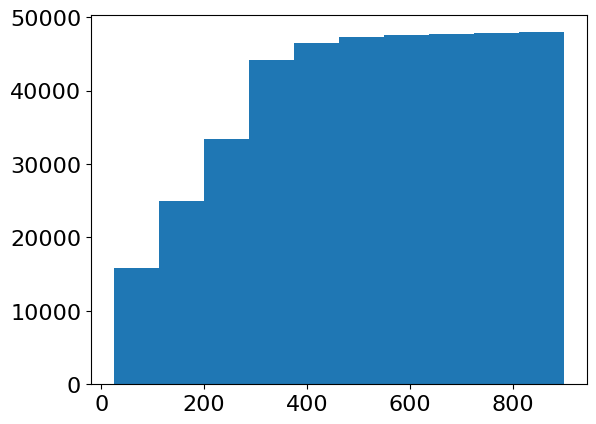

In [ ]:
# to visualize that of the 4800 ts we have, more than 4000 have less than 400
# samples, and nearly half have 200 samples

rng = (24., 900.)
plt.hist(length, range=rng, cumulative=True)

## Inspect data

In [ ]:
# convert to dataframe to make it simpler to analyze
# we visualize the shape: number of samples x standardized size

df = pd.DataFrame(data=data)
print(df.shape)

(48000, 2776)


In [ ]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.478704,0.412963,0.501852,0.756481,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.628000,0.624000,0.644000,0.688000,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959741,0.949098,0.919297,0.916705,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411765,0.307030,0.325681,0.361549,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340909,0.522727,0.568182,0.772727,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.642857,0.642857,0.653061,0.663265,0.663265,0.673469,0.653061,0.653061,0.632653,0.642857
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.631702,0.682984,0.727273,0.822844,0.815851,0.841492,0.878788,0.841492,0.841492,0.834499
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.680000,0.715000,0.738750,0.812500,0.797500,0.828750,0.862500,0.862500,0.876250,0.895000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054274,0.050204,0.073270,0.097693,0.100407,0.119403,0.130258,0.124830,0.132972,0.104478
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.120504,0.103417,0.111511,0.117806,0.107914,0.107014,0.098921,0.098022,0.091727,0.095324


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [ ]:
# we change the type of the samples for efficiency (as we work with 6 decimal
# digit samples, it should suffice float32)

df = df.astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB


In [ ]:
# we add the 'real' interval directly to each time series in the dataframe,
# with 2 new columns.
# so that now we can forget the "periods" array (and similar for categories)

df['Start'] = periods[:,0]
df['End'] = periods[:,1]
df['Category'] = categories

In [ ]:
# we shuffle the order of the ts (not *inside* the ts!), to get rid of any
# posible existing order, which wouldn't help the training.
# we reset the indexes according to the new positions

df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2769,2770,2771,2772,2773,2774,2775,Start,End,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.601933,0.639848,0.409208,0.151259,0.183186,0.266565,0.403581,2703,2776,C
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.754183,0.740621,0.724421,0.721276,0.702341,0.708480,0.720463,2581,2776,B
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.562132,0.627639,0.661737,0.643021,0.640349,0.598605,0.639099,2613,2776,B
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.675498,0.679844,0.690941,0.688087,0.713021,0.723866,0.690007,2595,2776,D
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.664118,0.742549,0.777290,0.773533,0.792240,0.764940,0.728696,2362,2776,D
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.530155,0.594949,0.533755,0.557655,0.582954,0.153346,0.125604,2538,2776,D
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.505081,0.534742,0.383979,0.399032,0.342313,0.335126,0.525874,2703,2776,C
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.317073,0.268293,0.170732,0.121951,0.121951,0.146341,0.195122,2725,2776,E
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.645161,0.766129,0.782258,0.782258,0.717742,0.750000,0.645161,2726,2776,E
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.961480,0.963265,0.960204,0.939286,0.921684,0.864286,0.865051,2560,2776,C


In [ ]:
# we see data probably normalized btw 0 and 1; to see better...
# (even if each column in general refers to different "actual" timestamps!)

df.describe()

,0,1,2,3,4,5,6,7,8,9,...,2768,2769,2770,2771,2772,2773,2774,2775,Start,End
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,...,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.0
mean,0.000004,0.000004,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.528503,0.533299,0.530825,0.525855,0.522132,0.523433,0.530226,0.531927,2577.699771,2776.0
std,0.000837,0.000813,0.000781,0.000760,0.000757,0.000749,0.000745,0.000741,0.000741,0.000733,...,0.287716,0.288655,0.289785,0.291925,0.296271,0.302170,0.303567,0.304784,137.406295,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2776.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.275296,0.276525,0.269440,0.259259,0.246887,0.242881,0.246772,0.244700,2488.000000,2776.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.546886,0.556100,0.552312,0.544393,0.542242,0.550017,0.561833,0.564695,2592.000000,2776.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.788449,0.795617,0.794872,0.793385,0.794734,0.802337,0.809368,0.815334,2712.000000,2776.0
max,0.183319,0.178061,0.171051,0.166542,0.165793,0.164041,0.163324,0.162288,0.162288,0.160536,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2752.000000,2776.0


In [ ]:
# we consider the transposed dataset, where each column is a ts.
# So we can see the max and the min for each ts. We notice that the
# normalization is a min-max one but not done on the single ts; as
# some don't ever reach 1, but on whole dataset.

df_t = df.transpose()

In [ ]:
df_t.describe()

,0,1,2,3,4,5,6,7,8,9,...,47990,47991,47992,47993,47994,47995,47996,47997,47998,47999
count,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0,...,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0,2779.0
unique,77.0,198.0,166.0,184.0,417.0,241.0,76.0,31.0,40.0,209.0,...,28.0,223.0,88.0,55.0,194.0,222.0,158.0,54.0,31.0,295.0
top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,2703.0,2582.0,2614.0,2596.0,2363.0,2539.0,2704.0,2727.0,2727.0,2561.0,...,2729.0,2489.0,2669.0,2725.0,2572.0,2489.0,2532.0,2513.0,2489.0,2481.0


In [ ]:
# notice we have no explicit timestamp and a single feature!

In [ ]:
def inspect(cat, df):
    dp = df[df['Category'] == cat]
    dp = dp.iloc[np.random.randint(len(dp))]

    figs, axs = plt.subplots(1, figsize=(17,10))
    axs.plot(dp[:-3])
    axs.set_title(cat)
    plt.show()

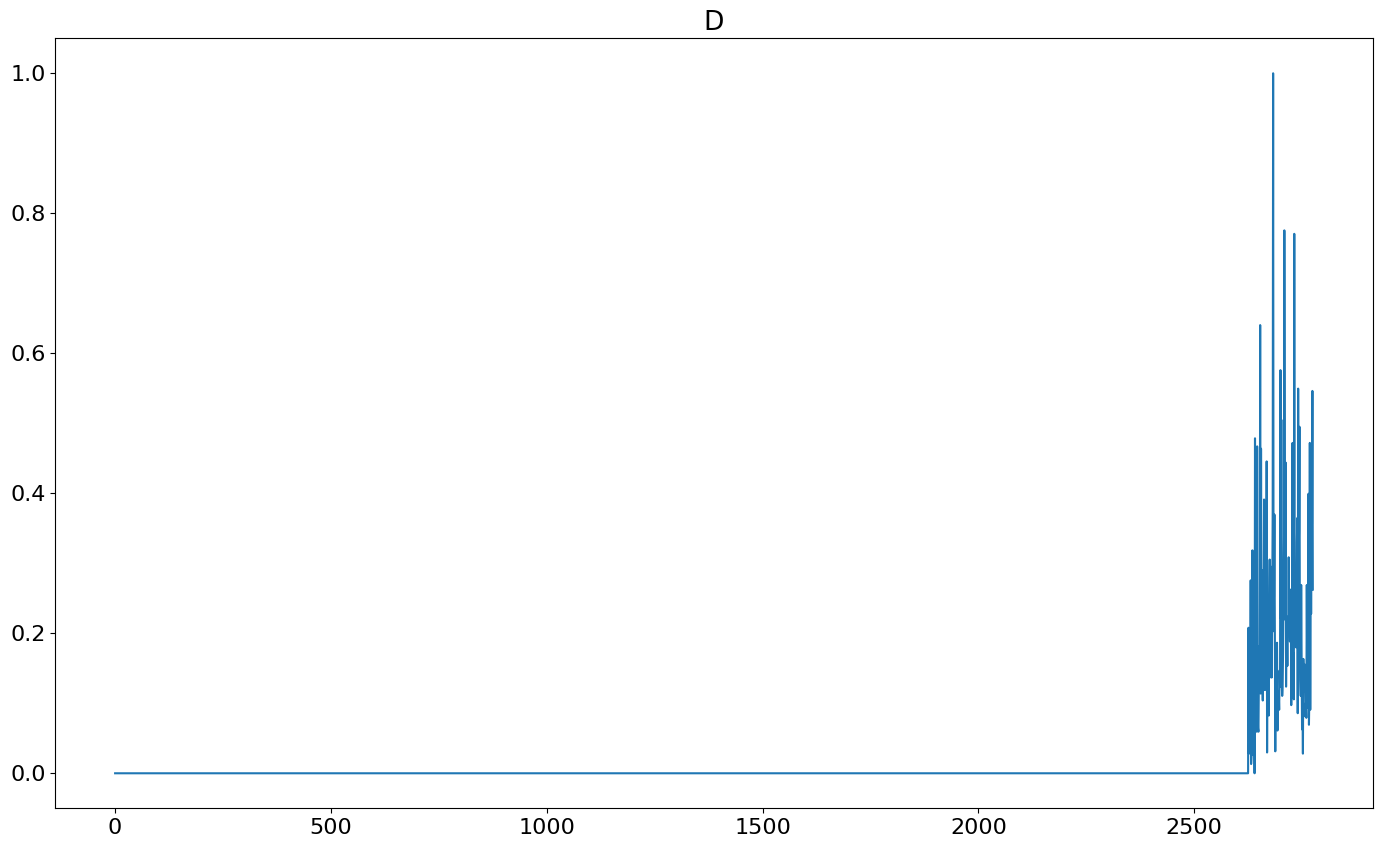

In [ ]:
# by plotting some random ones, it seems there are no evident differences btw
# the types in the behaviour of the plot; see the preprocessing notebook for
# a more detailed analysis

inspect('D', df)

## Inspect categories


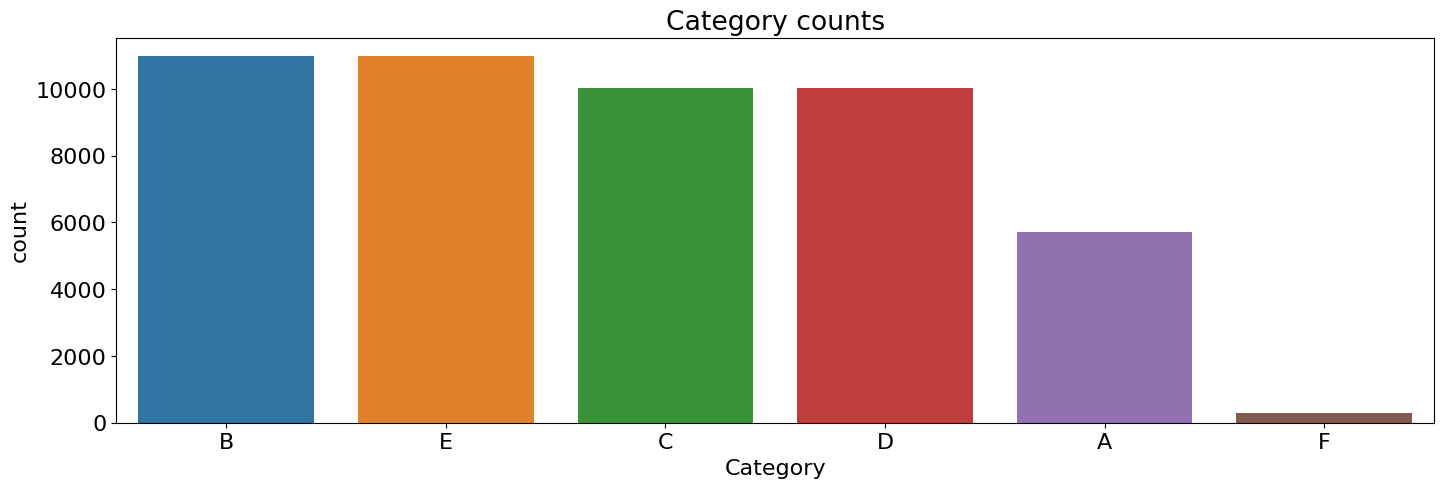

Category
B    10987
E    10975
C    10017
D    10016
A     5728
F      277
Name: count, dtype: int64


In [ ]:
# we see there is data unbalance for A and very much for F
# this is an issue, which will be treated later

plt.figure(figsize=(17,5))
sns.countplot(x = 'Category', data = df, order = df.Category.value_counts().index)
plt.title('Category counts')
plt.show()

print(df.Category.value_counts())

# Splitting and windowing

In [ ]:
# we want to create a uniform test set, reserving some ts excusively for testing
# purposes.
# How many ts in the test set? S.t. we'll take about 10% of the F-tss rows (so
# 27 rows, see above) for each category.

In [ ]:
# we should take some ts for each category, so that their amount
# of samples is of the desired quantity (test_size). We simply
# take the first test_size time series for each category.
# We remove those from the original dataframe, returning this one
# updated and a new test dataframe.

def build_test_set(df, test_size):
    test_df = pd.DataFrame(columns=df.columns)

    for category in df['Category'].unique():
        temp_df = df[df['Category'] == category][:test_size]
        test_df = pd.concat([test_df, temp_df], ignore_index=True)
        df = df.drop(temp_df.index)

    df = df.reset_index(drop=True)
    return df, test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
df, test_df = build_test_set(df, 27)

In [ ]:
# we inspect the result obtained

test_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2769,2770,2771,2772,2773,2774,2775,Start,End,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.785765,0.489680,0.655516,0.869039,0.949466,0.975089,0.945196,2560,2776,C
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.798007,0.800607,0.788781,0.802137,0.799347,0.822066,0.827613,2581,2776,B
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.799387,0.789553,0.766835,0.755472,0.752882,0.758805,0.767050,2432,2776,B
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.715909,0.551136,0.755682,0.886364,0.829545,0.880682,0.767045,2608,2776,A
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.638368,0.997795,0.997795,0.997795,1.000000,1.000000,1.000000,2560,2776,B
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.887998,0.891149,0.902893,0.900029,0.902320,0.914351,0.925523,1708,2776,F
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.360299,0.135664,0.360299,0.670180,0.135664,0.048924,2728,2776,F
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.785908,0.672087,0.626016,0.780488,0.910569,0.940379,0.910569,2488,2776,D
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.083333,0.104167,0.187500,0.375000,0.375000,0.208333,0.583333,2504,2776,B
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.743363,0.696165,0.716814,0.705015,0.758112,0.755162,0.792035,2601,2776,F


In [ ]:
# we inspect the total length and that of the single categories
# inside the test dataset.
# however test and validation very small compared to training set...
# but it is because we are limited by F small numbers. We want to
# have the same number of test tss for all categories, but we can't
# take too much for F; we take 20% ca. of it. But it must be the
# same for the others, if not to lose uniformness

print(len(test_df))
print(len(test_df[test_df['Category'] == 'F']))

162
27


In [ ]:
# we check the original dataset is deprived of the test-set rows

print(len(df))
df.head(10)

47838


,0,1,2,3,4,5,6,7,8,9,...,2769,2770,2771,2772,2773,2774,2775,Start,End,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.627451,0.549020,0.411765,0.333333,0.294118,0.254902,0.254902,2725,2776,D
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.655837,0.598568,0.601322,0.590859,0.599119,0.648128,0.645925,2488,2776,E
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.805921,0.671053,0.700658,0.680921,0.707237,0.700658,0.687500,2655,2776,C
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.247922,0.178436,0.445448,0.443625,0.161039,0.155511,0.292077,2442,2776,D
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.915663,0.901606,0.887550,0.851406,0.831325,0.801205,0.789157,2488,2776,C
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.900000,0.865000,0.900000,0.915000,0.925000,0.950000,0.960000,2488,2776,B
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.513314,0.689743,0.545688,0.536678,0.403920,0.593900,0.504100,2703,2776,C
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.533333,0.533333,0.542857,0.561905,0.638095,0.814286,0.885714,2488,2776,E
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.928813,0.792754,0.735475,0.643320,0.668602,0.637697,0.463918,2619,2776,C
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.392130,0.330982,0.525478,0.496135,0.703268,0.723691,0.740422,2704,2776,D


In [ ]:
# we repeat for the validation set

df, val_df = build_test_set(df, 27)

In [ ]:
# here we check systematically that we have no time series belonging
# to two different sets

intersection_test = df.merge(test_df).empty
print(intersection_test)
intersection_val = val_df.merge(test_df).empty
print(intersection_val)

True
True


In [ ]:
# we choose the window and the telescope according to the task we have to do
# on the test set.

window = 200
telescope = 9
autoregressive_tel = 1 # see later
stride = 20

In [ ]:
# this takes a ts, divides it in windows and puts them in the a parameter list;
# for each of these windows, we create a "future" window of a number of following
# samples, to put in another list. The dimensions if the 2 windows and the stride
# are passed as parameters.

def build_sequences(row, dataset, labels, window=200, telescope=9, stride=20):
    assert window % stride == 0

    # we take the meaningful samples from the row (a pandas.Series object)
    # we also exclude Start, End and Category columns
    row = row[int(row.Start):int(row.End)]
    padding_check = len(row)%window

    # if the sequence is not a multiple of 'window' long, we must add some 0s,
    # at the beginning
    if(padding_check != 0):
        padding_len = window - len(row)%window
        padding = np.zeros(padding_len, dtype='float32')
    else:
        padding = np.zeros(0)

    temp_row = np.concatenate((padding,row))
    assert len(temp_row) % window == 0

    # we split the ts in windows which will make the input data, and in
    # another set of windows which will make the predictions
    for idx in np.arange(0, len(temp_row)-window-telescope, stride):
        dataset.append(temp_row[idx:idx+window])
        labels.append(temp_row[idx+window:idx+window+telescope])

    del temp_row

In [ ]:
# we build the windowed training set iterating over all rows of the dataframe
# note the labels are made of 1 sample only: as we chose to use an autoregressive
# model (see later)

training_dataset = []
training_labels = []

for row in df.itertuples():
    build_sequences(row, training_dataset, training_labels, window=window,
                    telescope=autoregressive_tel, stride=stride)

In [ ]:
# this change in dimensionality is needed to feed the data to the following
# model

training_dataset = np.expand_dims(np.array(training_dataset), axis=2)
training_labels = np.expand_dims(np.array(training_labels), axis=1)

In [ ]:
print(training_dataset.shape)
print(training_labels.shape)

(267310, 200, 1)
(267310, 1, 1)


In [ ]:
# we check each window has its label

print(len(training_dataset))
print(len(training_labels))

# we visualize one window input and label

i = 8
print(training_dataset[i])
print(training_labels[i])
print(type(training_dataset[i]))
print(type(training_dataset))

267310
267310
[[0.06349207]
 [0.03174603]
 [0.04761905]
 [0.03174603]
 [0.        ]
 [0.03174603]
 [0.03174603]
 [0.06349207]
 [0.03174603]
 [0.03174603]
 [0.04761905]
 [0.06349207]
 [0.07936508]
 [0.04761905]
 [0.06349207]
 [0.0952381 ]
 [0.11111111]
 [0.14285715]
 [0.15873016]
 [0.14285715]
 [0.17460318]
 [0.14285715]
 [0.14285715]
 [0.12698413]
 [0.19047619]
 [0.19047619]
 [0.23809524]
 [0.25396827]
 [0.26984128]
 [0.30158731]
 [0.30158731]
 [0.30158731]
 [0.31746033]
 [0.2857143 ]
 [0.2857143 ]
 [0.2857143 ]
 [0.30158731]
 [0.36507937]
 [0.36507937]
 [0.38095239]
 [0.38095239]
 [0.41269842]
 [0.41269842]
 [0.41269842]
 [0.42857143]
 [0.42857143]
 [0.3968254 ]
 [0.41269842]
 [0.42857143]
 [0.49206349]
 [0.53968257]
 [0.5714286 ]
 [0.50793654]
 [0.53968257]
 [0.5714286 ]
 [0.5714286 ]
 [0.55555558]
 [0.52380955]
 [0.5714286 ]
 [0.5714286 ]
 [0.60317463]
 [0.58730161]
 [0.6825397 ]
 [0.6825397 ]
 [0.71428573]
 [0.74603176]
 [0.77777779]
 [0.74603176]
 [0.74603176]
 [0.73015875]
 [0.79

In [ ]:
# to print the data in a window, together with the predictions ground truth

def inspect_window(X, y, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(1, 1, figsize=(17,17))
    axs.plot(np.arange(len(X[idx])), X[idx])
    axs.scatter(np.arange(len(X[idx]), len(X[idx])+len(y[idx])), y[idx], color='orange')
    plt.show()

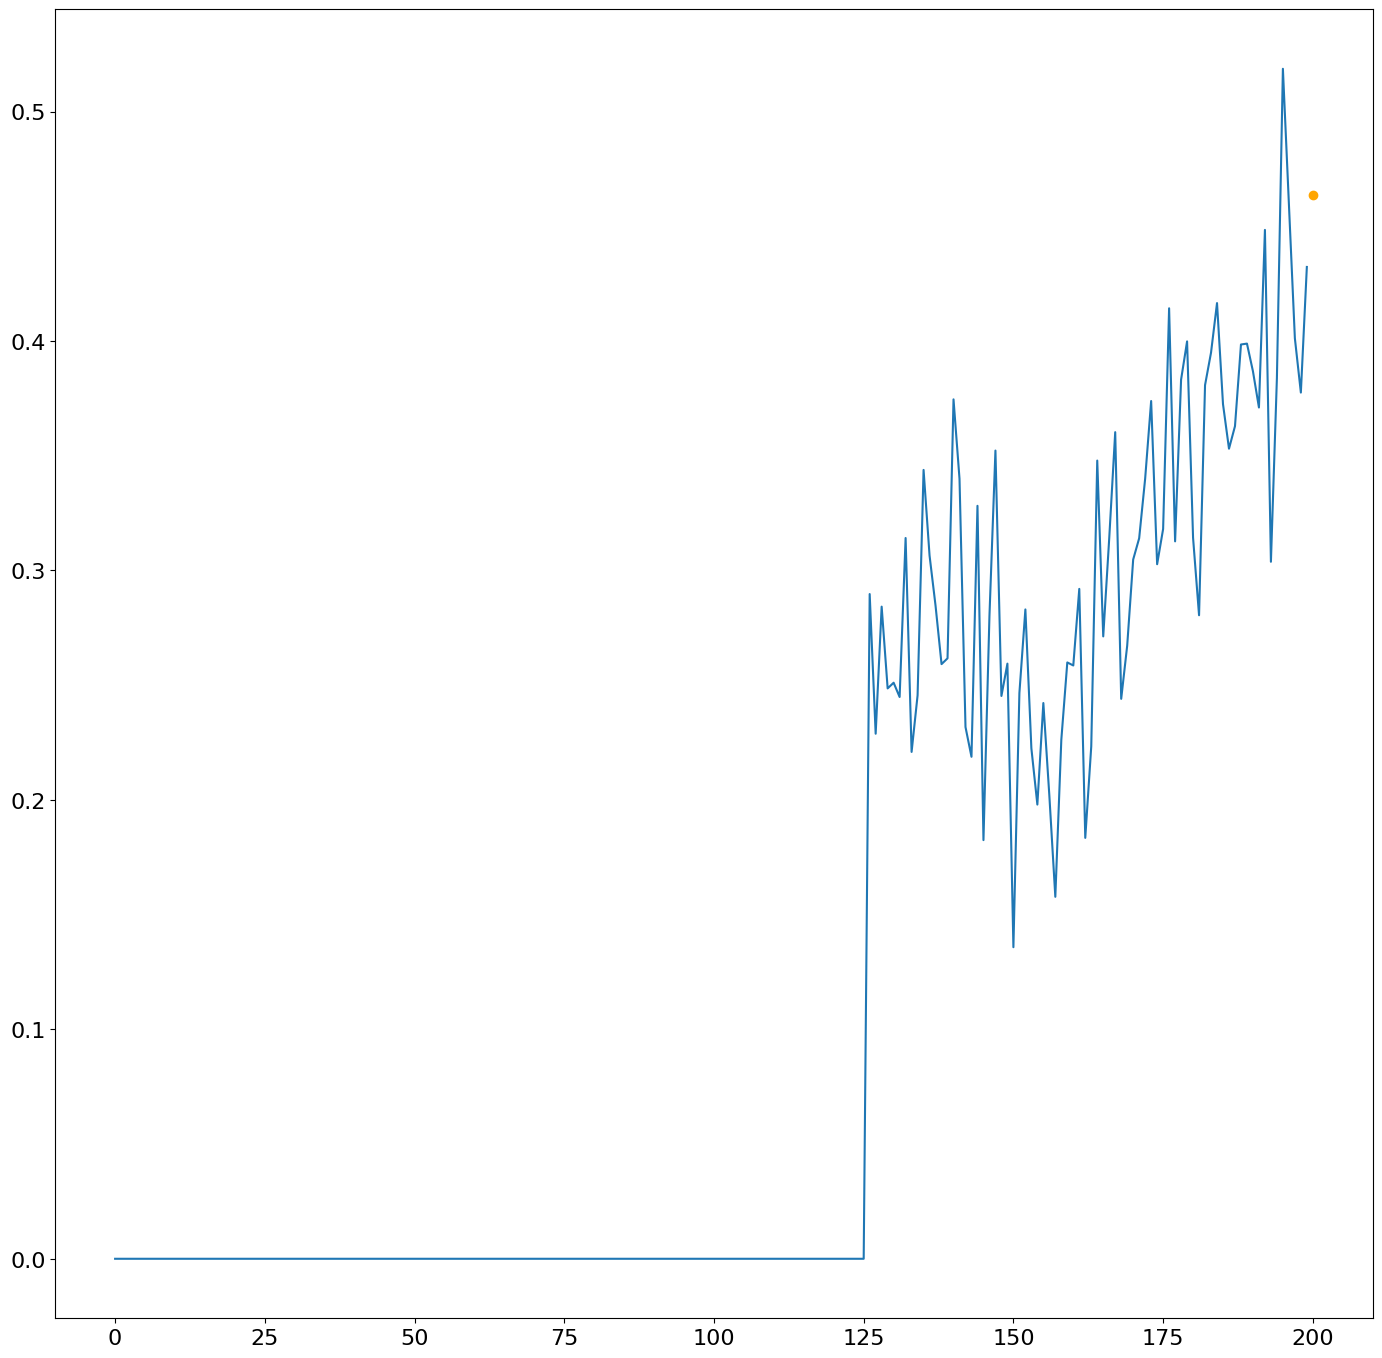

In [ ]:
inspect_window(training_dataset, training_labels)

In [ ]:
# can do the same for creating a windowed dataset for testing and validation

validation_dataset = []
validation_labels = []

for row in val_df.itertuples():
    build_sequences(row, validation_dataset, validation_labels, window=window,
                    telescope=autoregressive_tel, stride=stride)

validation_dataset = np.expand_dims(np.array(validation_dataset), axis=2)
validation_labels = np.expand_dims(np.array(validation_labels), axis=1)

In [ ]:
print(validation_dataset.shape)
print(validation_labels.shape)

(950, 200, 1)
(950, 1, 1)


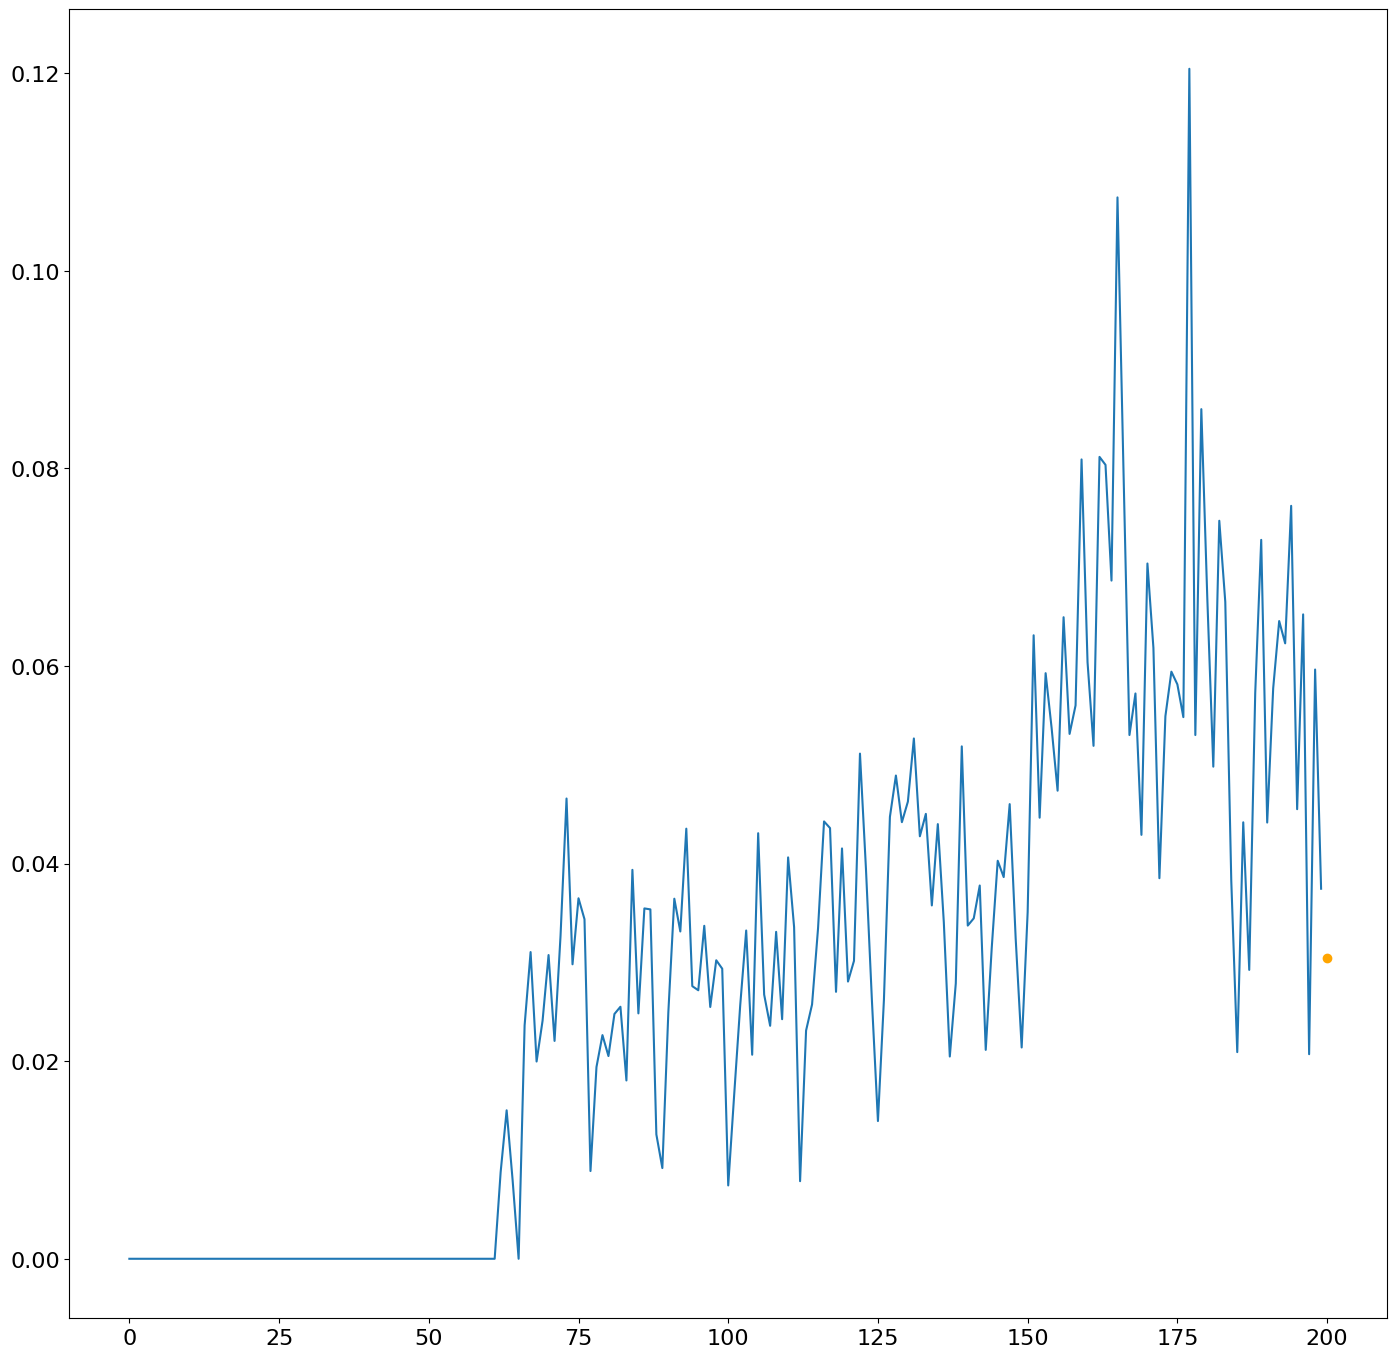

In [ ]:
inspect_window(validation_dataset, validation_labels)

In [ ]:
test_dataset = []
test_labels = []

for row in test_df.itertuples():
    build_sequences(row, test_dataset, test_labels, window=window,
                    telescope=autoregressive_tel, stride=stride)

test_dataset = np.expand_dims(np.array(test_dataset), axis=2)
test_labels = np.expand_dims(np.array(test_labels), axis=1)

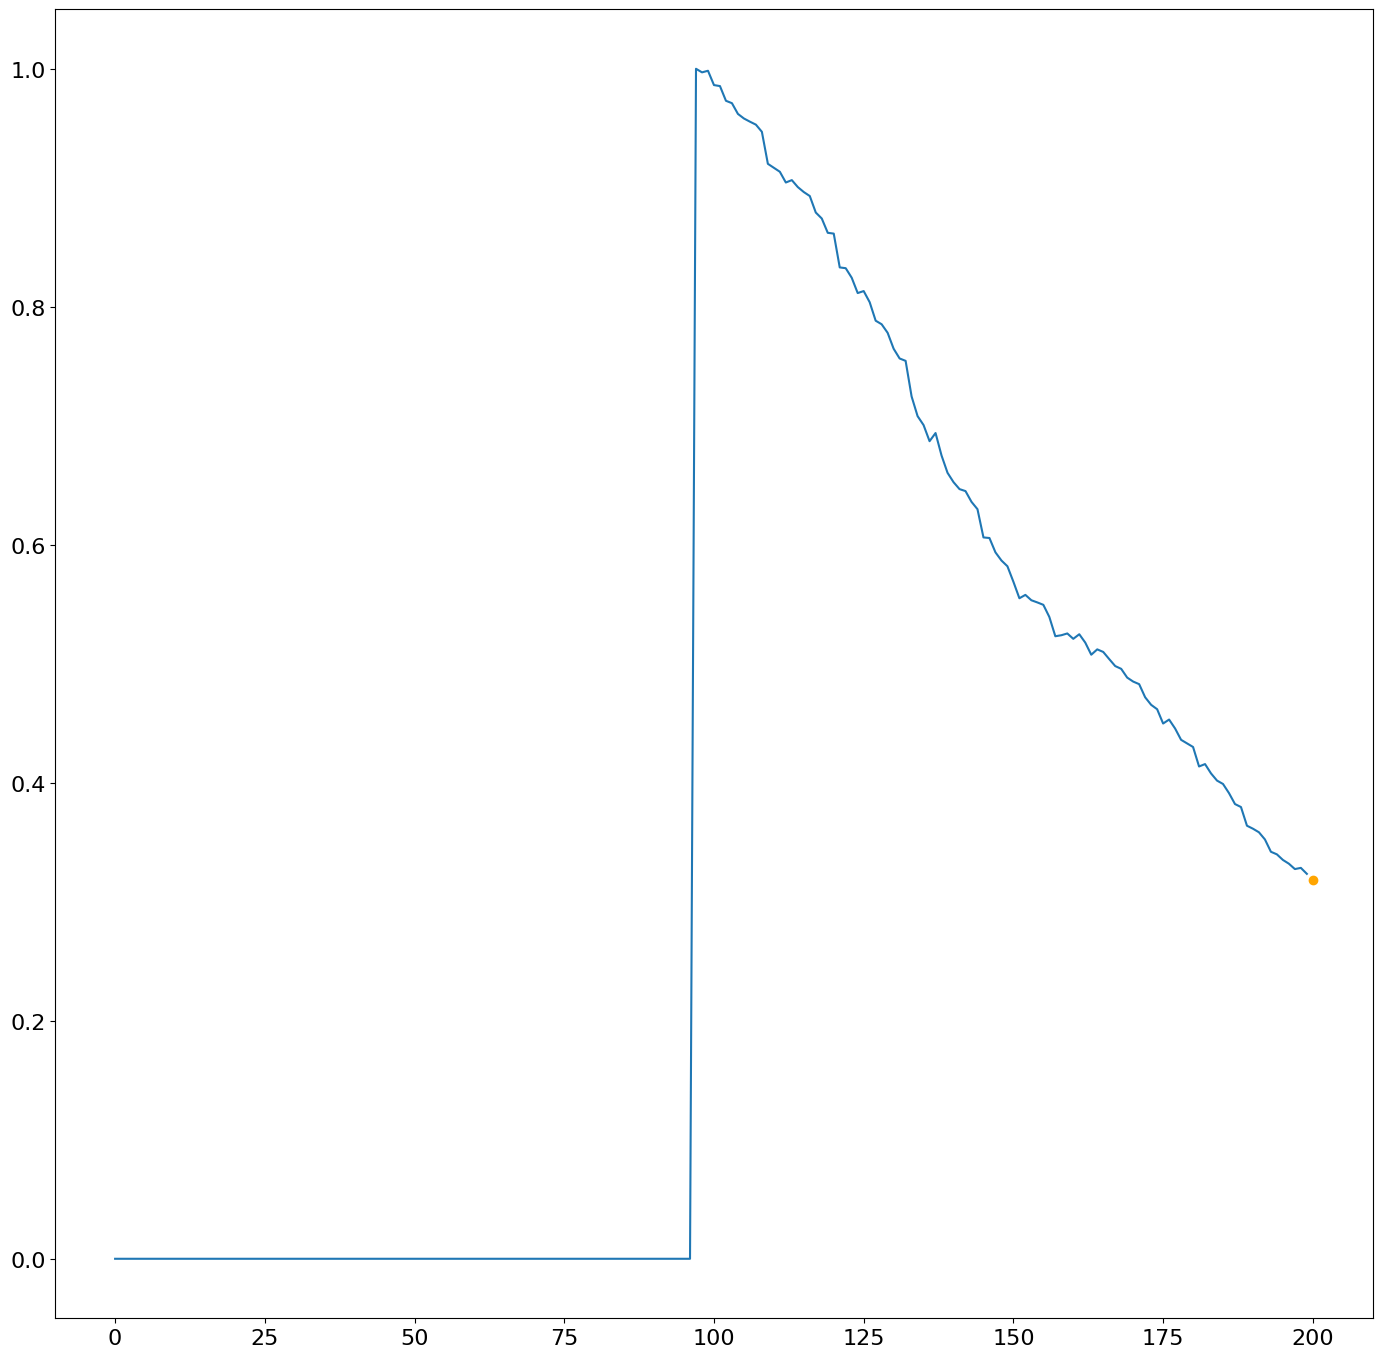

In [ ]:
inspect_window(test_dataset, test_labels)

# Model definition (architecture)

In [ ]:
# we extract some information needed to build the model and define its
# hyperparameters

input_shape = training_dataset.shape[1:]
output_shape = training_labels.shape[1:]
print(input_shape, output_shape)

batch_size = 64
epochs = 200

(200, 1) (1, 1)


In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], "We want input time steps to be >= of output time steps"

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # this is the core of the network, as described in the report.
    # It provides a representation which enables the rest of the network to forecast
    # the next value in the best way possible.
    # for each of the 200 samples of a window, we get at the end a 128-sized vector
    # of floats: so 200 x 128 for each element of the batch
    y = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(y)
    x = tfkl.Attention(name='att')([x,x])

    # we condense the output of the previous layer, reducing to 1 the second dimension in
    # each batch
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # here we crop the output so to be only 1 prediction
    crop_size = output_layer.shape[1] - output_shape[0]
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 128)             33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 conv (Conv1D)               (None, 200, 128)             49280     ['bidirectional_lstm[0][0]']  
                                                                                                  
 attention (Attention)       (None, 200, 128)             0         ['conv[0][0]',  

# Model training and results

In [ ]:
history = model.fit(
    x = training_dataset,
    y = training_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (validation_dataset, validation_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        # important, otherwise this architecture will tend to overfit the training set
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
4177/4177 [==============================] - 102s 22ms/step - loss: 0.0084 - val_loss: 0.0051 - lr: 0.0010
Epoch 2/200
4177/4177 [==============================] - 91s 22ms/step - loss: 0.0041 - val_loss: 0.0039 - lr: 0.0010
Epoch 3/200
4177/4177 [==============================] - 90s 22ms/step - loss: 0.0036 - val_loss: 0.0038 - lr: 0.0010
Epoch 4/200
4177/4177 [==============================] - 90s 22ms/step - loss: 0.0035 - val_loss: 0.0039 - lr: 0.0010
Epoch 5/200
4177/4177 [==============================] - 90s 22ms/step - loss: 0.0034 - val_loss: 0.0035 - lr: 0.0010
Epoch 6/200
4177/4177 [==============================] - 90s 22ms/step - loss: 0.0033 - val_loss: 0.0036 - lr: 0.0010
Epoch 7/200
4177/4177 [==============================] - 90s 22ms/step - loss: 0.0033 - val_loss: 0.0036 - lr: 0.0010
Epoch 8/200
4177/4177 [==============================] - 90s 22ms/step - loss: 0.0032 - val_loss: 0.0039 - lr: 0.0010
Epoch 9/200
4177/4177 [==============================] 

## Results and testing

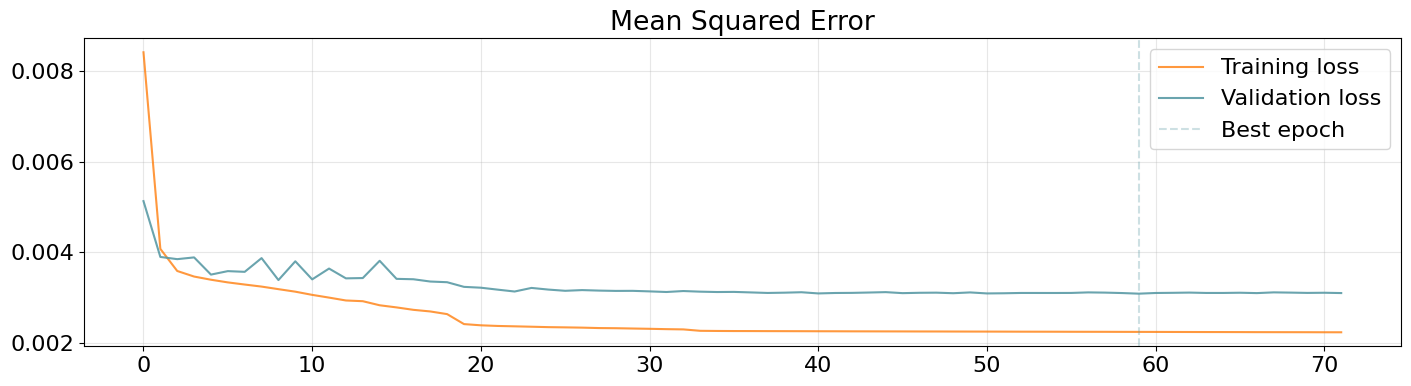

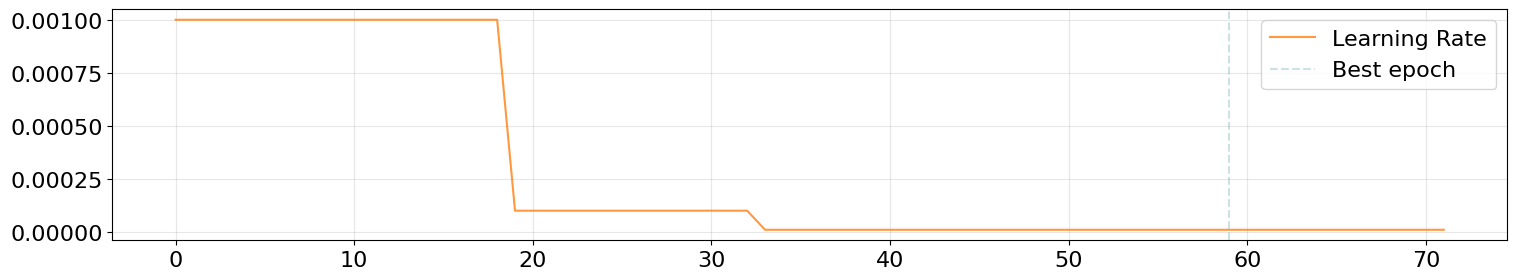

In [ ]:
# by inspecting the history and the plots, we see the model doesn't overfit much,
# keeping a similar result in the validation set w.r.t. the training

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# we compute performance over test set, with forecast horizon = 1
# we see the model manages to keep its performance.

predictions = model.predict(test_dataset, verbose=0)

print(f"Predictions shape: {predictions.shape}")

mean_squared_error = tfk.metrics.mean_squared_error(test_labels.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

mean_absolute_error = tfk.metrics.mean_absolute_error(test_labels.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (1050, 1, 1)
Mean Squared Error: 0.00208675698377192
Mean Absolute Error: 0.023989906534552574


## Autoregression: predict more than 1 sample

In [ ]:
# we build a new test set, where each label consists of 9 samples now
# (the same could be repeated for 18 samples by changing telescope value)

test_dataset_multistep = []
test_labels_multistep = []

for row in test_df.itertuples():
    build_sequences(row, test_dataset_multistep, test_labels_multistep,
                    window=window, telescope=telescope, stride=stride)

test_dataset_multistep = np.expand_dims(np.array(test_dataset_multistep), axis=2)
test_labels_multistep = np.expand_dims(np.array(test_labels_multistep), axis=2)

In [ ]:
test_dataset_multistep.shape, test_labels_multistep.shape

((1050, 200, 1), (1050, 9, 1))

In [ ]:
# to predict more samples with autoregressive forecasting, we predict one sample,
# then put it inside the input, remove the oldest sample in the input, and repeat
# using the "updated" input

def predict_multistep(model, X_test, telescope=9, autoregressive_telescope=1):
    predictions = np.array([])
    X_temp = X_test
    for reg in range(0,telescope,autoregressive_telescope):
        pred = model.predict(X_temp,verbose=0)
        if(len(predictions)==0):
            predictions = pred
        else:
            predictions = np.concatenate((predictions,pred),axis=1)
        X_temp = np.concatenate((X_temp[:,autoregressive_telescope:,:],pred), axis=1)

    return predictions

In [ ]:
prediction_multistep = predict_multistep(model, test_dataset_multistep,
                                         telescope=telescope,
                                         autoregressive_telescope=autoregressive_tel)

In [ ]:
# measure performance over output window of 9 samples

print(f"Predictions shape: {prediction_multistep.shape}")

mean_squared_error = tfk.metrics.mean_squared_error(test_labels_multistep.flatten(),
                                                    prediction_multistep.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

mean_absolute_error = tfk.metrics.mean_absolute_error(test_labels_multistep.flatten(),
                                                      prediction_multistep.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (1050, 9, 1)
Mean Squared Error: 0.006378748454153538
Mean Absolute Error: 0.046268511563539505


In [ ]:
model.save('/kaggle/working/convlstm1')